#### Exercise 5 (3 points): ARMA and GARCH models
__Guided exercise__. 
1. Retrieve the daily (monthly) asset price (macro-variable) of your choice from YahooFinance (or from DBnomics).
2. Fit the appropriate **__SARIMA-GARCH__** models to this time series by
using a rolling window of $4$ years with a frequency of $1$ day ($1$ month) to re-estimate your model from **__January 1, 2016__** to **__June 30, 2020__**. 
3. Use your fitted models to produce $1$-step ahead forecasts on the
out-of-sample period (from **__January 1, 2020__** until **__June 30, 2020__**). 

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf
from datetime import datetime
import itertools

In [2]:
sns.set_theme(style="darkgrid")
# Import data
yf.ticker = "^FVX"  # 5 year Treasury

# Retrive the data for the relevant time period
start = datetime(2016, 1, 1)
end = datetime(2020, 6, 30)
data_yf = yf.download("^FVX", start, end)
data_yf = data_yf["Adj Close"].dropna()
ts = pd.DataFrame(data=data_yf, columns=["Adj Close"]).rename(
    columns={"Adj Close": "Yield"}
)

[*********************100%%**********************]  1 of 1 completed


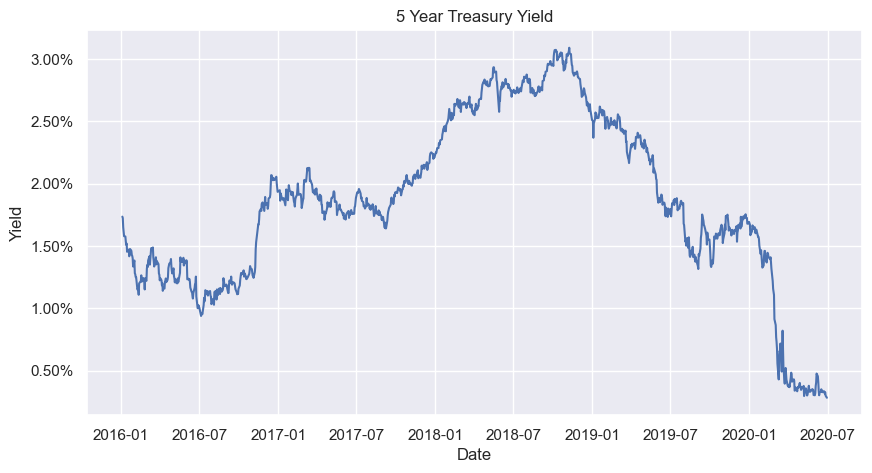

In [3]:
# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(ts)
plt.gca().yaxis.set_major_formatter(lambda y, _: f"{y/100:.2%}")
plt.title("5 Year Treasury Yield")
plt.ylabel("Yield")
plt.xlabel("Date")
plt.show()

In [4]:
# Check for stationarity of the data
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts["Yield"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
if result[1] > 0.05:
    print("The data is not stationary")
else:
    print("The data is stationary")

ADF Statistic: 0.227184
p-value: 0.973746
The data is not stationary


In [5]:
# Modifying the data to make it stationary
ts["Yield Diff"] = ts["Yield"].diff()
ts = ts.dropna()

# Test for stationarity again
result = adfuller(ts["Yield Diff"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
if result[1] > 0.05:
    print("The data is not stationary")
else:
    print("The data is stationary")

ADF Statistic: -34.834464
p-value: 0.000000
The data is stationary


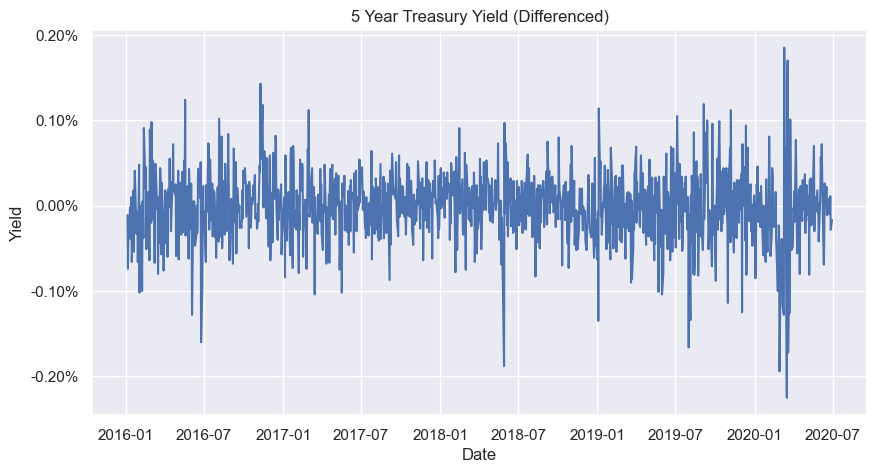

In [6]:
# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(ts["Yield Diff"])
plt.gca().yaxis.set_major_formatter(lambda y, _: f"{y/100:.2%}")
plt.title("5 Year Treasury Yield (Differenced)")
plt.ylabel("Yield")
plt.xlabel("Date")
plt.show()

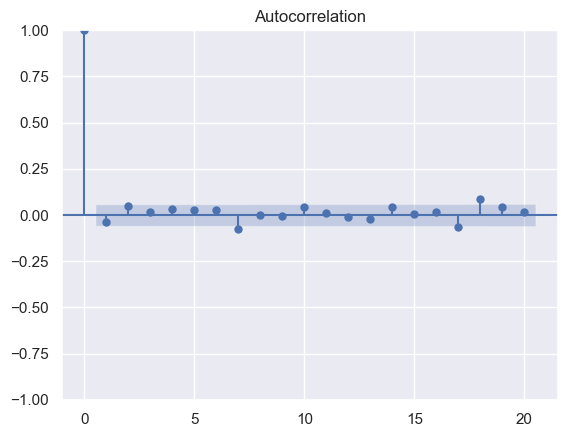

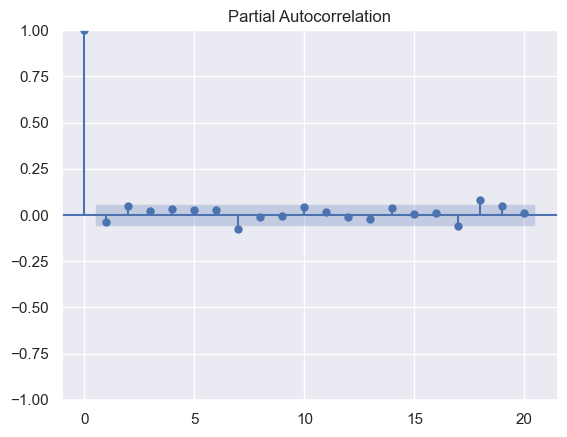

In [7]:
# ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts["Yield Diff"], lags=20)
plot_pacf(ts["Yield Diff"], lags=20)
plt.show()

In [8]:
# Check for ARCH effects
from statsmodels.stats.diagnostic import het_arch

result = het_arch(ts["Yield Diff"])
print("Lagrange Multiplier Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("f-value: %f" % result[2])
print("f p-value: %f" % result[3])

if result[1] > 0.05:
    print("The data is not ARCH")
else:
    print("The data is ARCH")

Lagrange Multiplier Statistic: 170.773638
p-value: 0.000000
f-value: 19.960937
f p-value: 0.000000
The data is ARCH


/Users/romaincastellarnau/opt/anaconda3/envs/M2CLASS/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/romaincastellarnau/opt/anaconda3/envs/M2CLASS/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/romaincastellarnau/opt/anaconda3/envs/M2CLASS/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


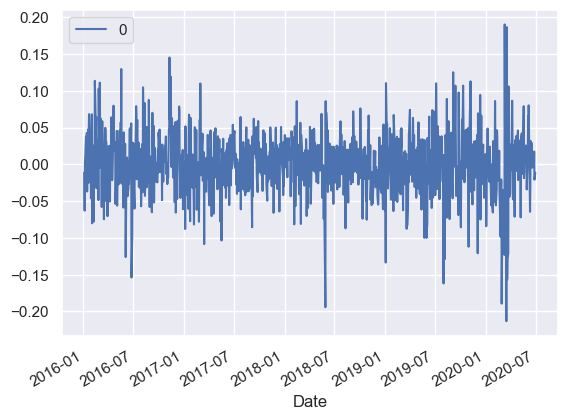

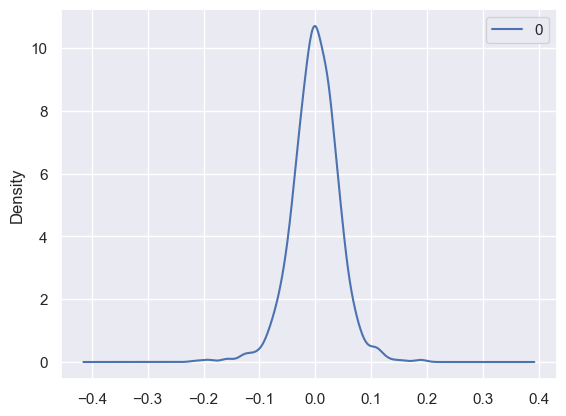

                 0
count  1127.000000
mean      0.000404
std       0.042222
min      -0.213272
25%      -0.023620
50%       0.000670
75%       0.025697
max       0.190246


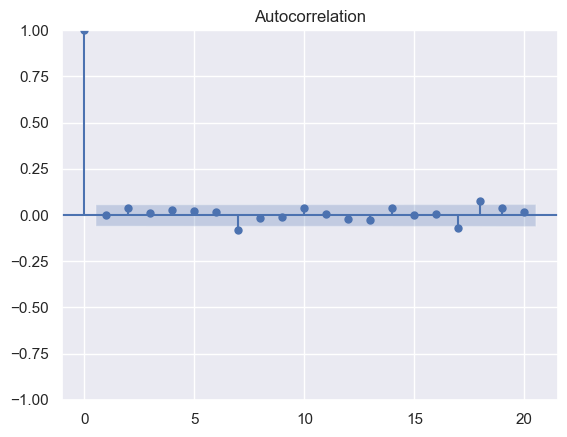

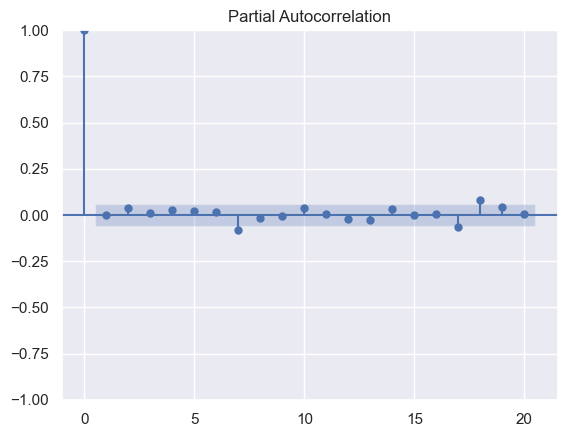

In [9]:
#Check ACF and PACF plots for the residuals of the model
from statsmodels.tsa.arima.model import ARIMA

model_base = ARIMA(ts["Yield Diff"], order=(1, 1, 1))
model_fit = model_base.fit()
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind="kde")
plt.show()
print(residuals.describe())

plot_acf(residuals, lags=20)
plot_pacf(residuals, lags=20)
plt.show()


In [11]:
from arch import arch_model
import itertools

ts["Yield Diff"] = ts["Yield Diff"] * 10

# Fit the model using a grid search
p = q = range(0, 5)
pq = list(itertools.product(p, q))
aic = []

for param in pq:
    try:
        mod = arch_model(ts["Yield Diff"], p=param[0], q=param[1])
        res = mod.fit()
        aic.append(res.aic)
    except:
        aic.append(None)

# Filter out None values before finding the minimum
min_aic = min(filter(lambda x: x is not None, aic), default=None)

if min_aic is not None:
    # Find the best parameters
    best = pq[aic.index(min_aic)]
    print("Best Parameters:", best)
else:
    print("No valid parameters found.")

Iteration:      1,   Func. Count:      5,   Neg. LLF: 3434.7149884959936
Iteration:      2,   Func. Count:     11,   Neg. LLF: 7219.327786547761
Iteration:      3,   Func. Count:     17,   Neg. LLF: 3223.7802246720366
Iteration:      4,   Func. Count:     22,   Neg. LLF: 3224.936314270687
Iteration:      5,   Func. Count:     27,   Neg. LLF: 3190.4874278166753
Iteration:      6,   Func. Count:     32,   Neg. LLF: 3188.7345584302357
Iteration:      7,   Func. Count:     36,   Neg. LLF: 3188.7028625325743
Iteration:      8,   Func. Count:     40,   Neg. LLF: 3188.7027578941916
Iteration:      9,   Func. Count:     44,   Neg. LLF: 3188.7027519054927
Iteration:     10,   Func. Count:     47,   Neg. LLF: 3188.7027519053568
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3188.7027519054927
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 85171.20

In [ ]:
# # Fit the ARIMA model using a grid search
# from statsmodels.tsa.arima.model import ARIMA

# # Define the p, d and q parameters to take any value between 0 and 2
# p = d = q = range(0, 3)

# # Generate all different combinations of p, q and q triplets
# pdq = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]
# aic = []
# for param in pdq:
#     try:
#         mod = ARIMA(ts["Yield"], order=param)
#         results = mod.fit()
#         aic.append(results.aic)
#     except:
#         continue